# 이미지 세그멘테이션, 아웃포커싱(Depth Map)

이미지 세그멘테이션 모델을 이용하여 사람 및 고양이와 같은 객체를 픽셀 단위로 분할한 후, 합성과 아웃포커싱을 수행하고자 합니다.

## 데이터
본 예제에서는 총 세 개의 이미지를 사용합니다. 이미지는 합성 배경으로 사용할 'Background' 이미지와 예제로 사용할 '고양이', '노트북을 하는 남자' 이미지를 이용 합니다.

In [1]:
import os   #디렉토리 관리

import cv2   #이미지 처리
import numpy as np   #행렬처리

import urllib   #웹에서 데이터를 다운로드  
import tarfile   #파일 관리

import tensorflow as tf   #신경망

#Depth Map
from keras.models import load_model
from layers import BilinearUpSampling2D
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt   #데이터 시각화

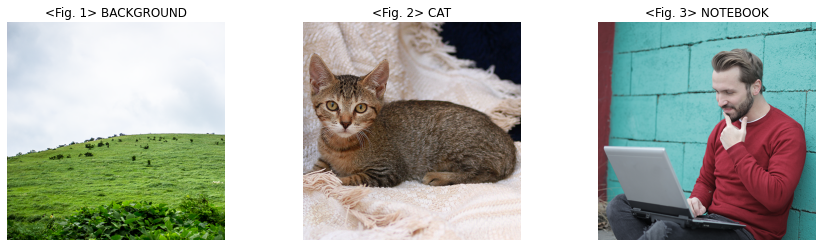

In [2]:
file_list = [file_ for file_ in os.listdir("./dataset/") if file_[-3:] == "png"]

plt.figure(figsize=(15, 4))
for idx, file_ in enumerate(file_list):
    file_name = file_[:-4]
    
    plt.subplot(1, 3, idx + 1)
    plt.axis("off")
    plt.title("<Fig. " + str(idx + 1) + "> " + file_name)
    
    img = cv2.imread("./dataset/" + file_, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

## 이미지 세그멘테이션

이미지 세그멘테이션은 이미지로부터 객체를 픽셀 단위로 분할하는 것 입니다. 본 예제에서는 이미지로부터 고양이 또는 사람을 픽셀 단위로 분할하여, 새로운 배경을 합성하거나 기존 배경을 흐리게 만들어 이미지를 편집하고자 합니다.

모델을 생성하고 이미 준비된 가중치를 모델에 적용 합니다. 또한, 이미지 불러오기와 시각화 같은 자주 사용되는 기능을 함수로 작성합니다.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### 가중치 불러오기
가중치를 불러옵니다. 모델을 텐서플로 페이지에서 받아올 수 있습니다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = "./human_segmentation/models"
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ./human_segmentation/models
model loaded successfully!


#### 시각화 함수
이미지 불러오기와 시각화 기능을 함수로 사용 합니다.

In [5]:
#이미지 불러오기
def load_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


#단일 이미지 시각화
def show_one_img(img, title, size=(5, 5)):
    plt.figure(figsize=size)
    plt.axis("off")
    plt.title(title)
    plt.imshow(img)
    plt.show()

### 세그멘테이션 진행하기
학습된 모델을 불러왔습니다. 고양이 이미지를 모델에 입력하여 픽셀 단위로 분할하고자 합니다. 각 필셀 별로 라벨링 넘버가 부여되어 출력 됩니다. 고양이의 경우 '8'이며, 사람의 경우에는 '15'에 해당합니다. 나아가 이후 이미지 편집에 사용할 이미지 마스크 획득 단계까지 진행해 보겠습니다.

#### 이미지 호출
예제로 사용할 고양이 이미지를 시각화 합니다. 크기는 512 x 512 x 3 입니다.

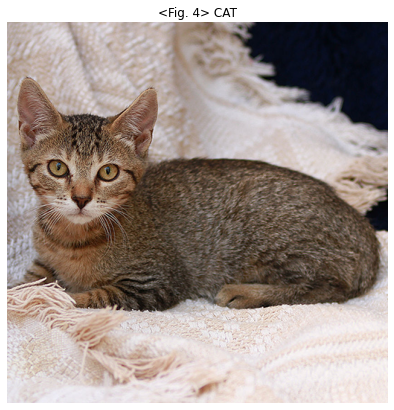

******************************
IMAGE SIZE: (512, 512, 3)
******************************


In [6]:
img = load_img("./dataset/CAT.png")
show_one_img(img, "<Fig. 4> CAT", (7, 7))

#출력부
print("*" * 30)
print("IMAGE SIZE:", img.shape)
print("*" * 30)

#### 모델을 통한 세그멘테이션
고양이 부분이 분할된 것을 확인 할 수 있는데, 우상단 부분에 잘못 분할 된 픽셀이 존재 합니다.

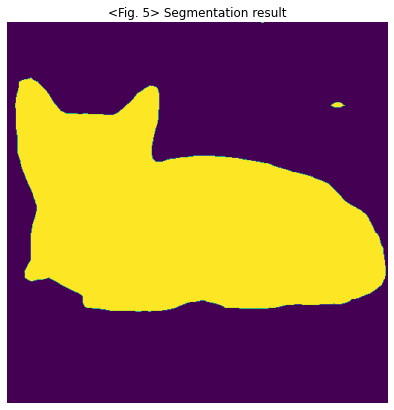

******************************
output size: (513, 513, 3)
seg_map max value: 8
******************************


In [7]:
img_resized, seg_map = MODEL.run(img)   #모델


#출력부
show_one_img(seg_map, "<Fig. 5> Segmentation result", (7, 7))

print("*" * 30)
print("output size:", img_resized.shape)
print("seg_map max value:", seg_map.max())
print("*" * 30)

#### 이미지 마스크
이미지 편집에 사용하기 위한 이미지 마스크를 얻습니다.

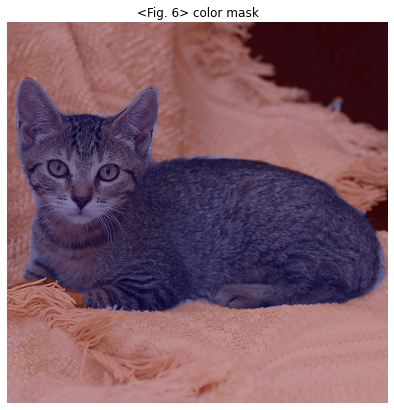

In [8]:
#이미지 마스크 획득 함수
def get_img_mask(seg_map, origin_size):
    seg_map = np.where(seg_map == seg_map.max(), seg_map.max(), 0)
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    
    img_mask_up = cv2.resize(img_mask, origin_size[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    return img_mask_up


img_mask = get_img_mask(seg_map, img.shape)


#시각화
img_show = img.copy()
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

show_one_img(img_show, "<Fig. 6> color mask", (7, 7))

## 배경 변경하기
이미지로부터 고양이 픽셀을 분할하였습니다. 따라서, 배경과 객체를 분리할 수 있습니다. '배경 변경하기' 예제에서는 새로운 배경에 앞서 획득한 이미지 마스크를 위치시킨 후, 분할한 고양이 이미지를 합성하여 최종적으로 배경을 변경합니다. 새로운 배경으로는 '언덕' 이미지를 시각화 하여 사용합니다

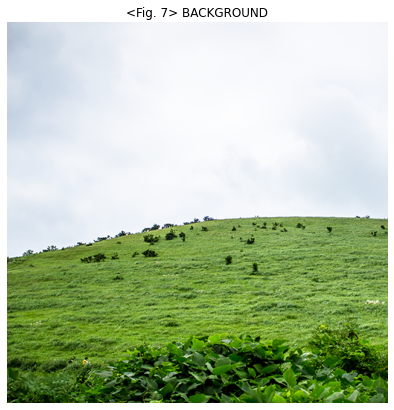

In [9]:
background = load_img("./dataset/BACKGROUND.png")
show_one_img(background, "<Fig. 7> BACKGROUND", (7, 7))

#### 이미지 합성
'언덕' 이미지에 고양이 이미지 마스크를 위치 시킨 후, 최종적으로 이미지를 합성 합니다.

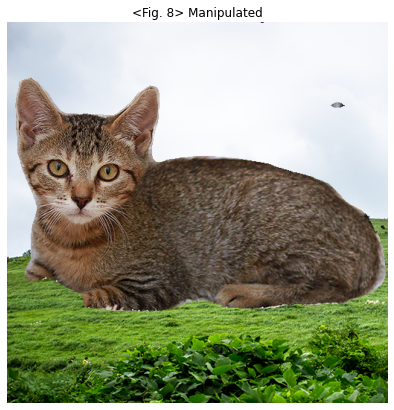

In [10]:
def masking_background(img_mask, background):
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2RGB)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(background, img_bg_mask)
    return [img_mask_color, img_bg_blur]

img_mask_color, img_bg_blur = masking_background(img_mask, background)   #마스킹 하기
img_concat = np.where(img_mask_color==255, img, img_bg_blur)   #이미지 합성


#출력부
show_one_img(img_concat, "<Fig. 8> Manipulated", (7, 7))

## 아웃포커싱
객체와 배경을 분리한 다음 새로운 배경을 적용하였습니다. 객체와 배경을 분리하고 기존 배경을 흐리게 만드는 블러(blur) 처리한 후 다시 객체를 이미지에 위치시킴으로써 '아웃포커싱'이 된 것 처럼 보이게 이미지를 편집 합니다. '배경 변경' 예제와 그 방법은 동일 합니다.

In [11]:
def get_outpocus(img):
    origin_size = img.shape
    
    img_resized, seg_map = MODEL.run(img)   #모델
    img_mask = get_img_mask(seg_map, origin_size)
    
    img_orig_blur = cv2.GaussianBlur(img, (0, 0), 2)   #가우시안 블러
    img_mask_color, img_bg_blur = masking_background(img_mask, img_orig_blur)   #마스킹 하기
    img_concat = np.where(img_mask_color==255, img, img_bg_blur)   #이미지 합성
    return img_concat

#### 아웃포커싱 효과 적용 
앞의 함수를 사용하여 'CAT.png'와 'NOTEBOOK.png'에 아웃포커싱 효과를 적용 합니다.

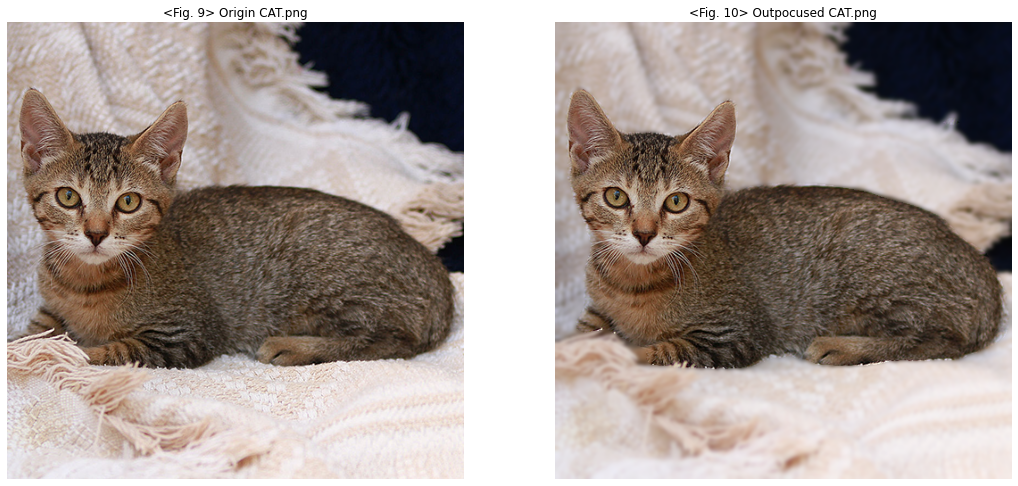

In [12]:
img = load_img("./dataset/CAT.png")
result_img = get_outpocus(img)


plt.figure(figsize=(18, 15))
plt.subplot(1, 2, 1)
plt.title("<Fig. 9> Origin CAT.png")
plt.axis("off")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("<Fig. 10> Outpocused CAT.png")
plt.axis("off")
plt.imshow(result_img)

plt.show()

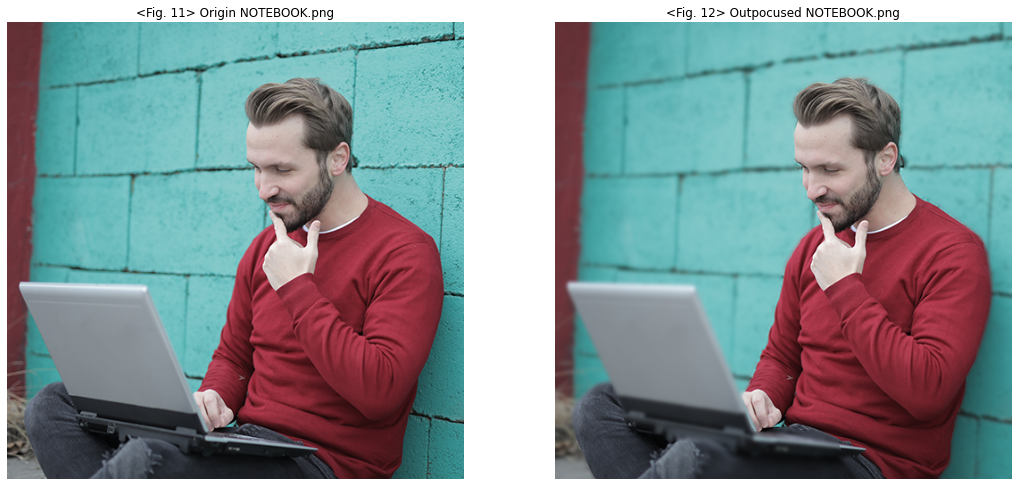

In [13]:
img = load_img("./dataset/NOTEBOOK.png")
result_img = get_outpocus(img)


plt.figure(figsize=(18, 15))
plt.subplot(1, 2, 1)
plt.title("<Fig. 11> Origin NOTEBOOK.png")
plt.axis("off")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("<Fig. 12> Outpocused NOTEBOOK.png")
plt.axis("off")
plt.imshow(result_img)

plt.show()

## Depth Map 사용
Depth Map은 이미지의 객체가 어느정도 깊이 있는지 수치적으로 제시해주는 것 입니다. 이미지 세그멘테이션의 경우 객체를 픽셀 단위로 분할한 것이라면, Depth Map의 경우 수치적으로 객체의 깊이를 픽셀 단위로 제시합니다.

아웃포커싱과 거리에 대해 이해할 필요가 있습니다. 우선 아웃 포커싱은 카메라의 조리개를 개방함으로써 피사계 심도가 낮아지게 되어, 특정 거리에 있는 사물에 초점을 맞추면 해당 거리로부터 멀어질 수록 흐려지게 됩니다. 따라서 같은 거리에 있는 경우에는 함께 선명해야 하며, 멀어질수록 흐려지도록 만들 필요가 있습니다.

따라서, 본 예제에서는 2D 이미지로부터 Depth Map을 추출할 수 있는 Ibraheem Alhashim(2018)이 제시한 DenseDepth 모델을 이용합니다. 해당 모델과 이미지 세그멘테이션을 응용하여 아웃포커싱 효과를 개선하고자 합니다.

### 아웃포커싱의 문제

세그멘테이션 모델만을 이용할 경우 발생하는 문제는 크게 두 가지 입니다. 우선, 거리를 고려하지 않고 객체를 제외한 모든 배경에 동일한 흐림(blur) 효과를 적용합니다. 그리고 인물을 객체로 삼은 경우, 인물이 무엇인가 들고있거나 쓰고있는 경우 발생하는 문제 입니다. 인물이 만약 아이스크림 콘을 들고있다면, 인물만 선명하고 아이스크림 콘은 블러 처리된 채로 이미지가 반환될 것 입니다.

이러한 문제는 객체의 거리를 고려하면 모두 해결 할 수 있습니다. 객체의 거리별로 블러 효과를 다르게 줄 수 있습니다. 또한, 인물이 무엇인가 들고 있어도 같은 거리에 있다면, 해당 사물은 인물과 함께 선명하게 나오게 됩니다. 따라서, Depth Map을 이용하여 해당 문제를 해결하고자 합니다. Depth Map을 이용한 '아웃포커싱' 효과에 대한 주요 아이디어는 '초점을 잡은 객체 즉, 세그멘테이션하여 선택한 객체로부터 멀리 떨어질 수록 더 흐리게 보이도록 하기' 입니다.

#### Ibraheem Alhashim
Ibraheem Alhashim(2018)의 모델을 불러 옵니다.

In [14]:
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
model = load_model("./model/nyu.h5", custom_objects=custom_objects, compile=False)

##### 출처
Ibraheem Alhashim, Peter Wonka. (2018). High Quality Monocular Depth Estimation via Transfer Learning.

#### Depth Map 획득하기
CAT.png 이미지의 Depth Map을 획득하고 시각화 합니다.
어두운 영역일 수록 가까운 것이며 밝을 수록 먼 것으로 이해할 수 있습니다.

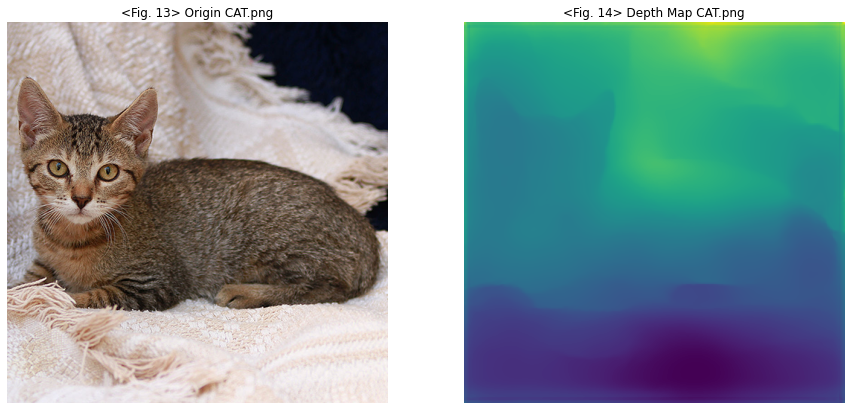

In [15]:
#depth map 획득 함수
def get_depth_map(img):
    minDepth, maxDepth = 10, 1000
    input_data = (img / 255).reshape(1, img.shape[0], img.shape[1], img.shape[2])
    output_data = model.predict(input_data)
    
    re_output_data = np.clip(maxDepth / output_data, minDepth, maxDepth) / maxDepth
    
    rescaled = re_output_data[0][:,:,0]
    rescaled = rescaled - np.min(rescaled)
    rescaled = rescaled / np.max(rescaled)
    return rescaled


#출력부
img = load_img("./dataset/CAT.png")
rescaled = get_depth_map(img)


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("<Fig. 13> Origin CAT.png")
plt.axis("off")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("<Fig. 14> Depth Map CAT.png")
plt.axis("off")
plt.imshow(rescaled)

plt.show()

#### 사물의 거리 정보
객체의 범위를 획득 합니다.

In [16]:
img_resized, seg_map = MODEL.run(img)
depth_img = cv2.resize(rescaled, dsize=seg_map.shape)   #resize

object_img = np.where(seg_map == seg_map.max(), 1, 0)   #객체 픽셀을 1로 변환
object_depth = depth_img * object_img   #객체에 해당하는 픽셀은 0을 초과 하는 것을 이용
background_max = depth_img.max()   #background의 가장 먼 거리
max_ = np.percentile(object_depth, 98.)   #객체의 가장 먼 거리
min_ = object_depth[np.where(object_depth > 0)].min()   #객체의 가장 가까운 거리


#출력부
print("*" * 30)
print("near:", round(min_, 3))
print("far:", round(max_, 3))
print("background far:", round(background_max, 3))
print("*" * 30)

******************************
near: 0.21
far: 0.622
background far: 1.0
******************************


#### 블러 영역 설정
거리별 영역을 구분한 후, 이를 시각화 합니다.

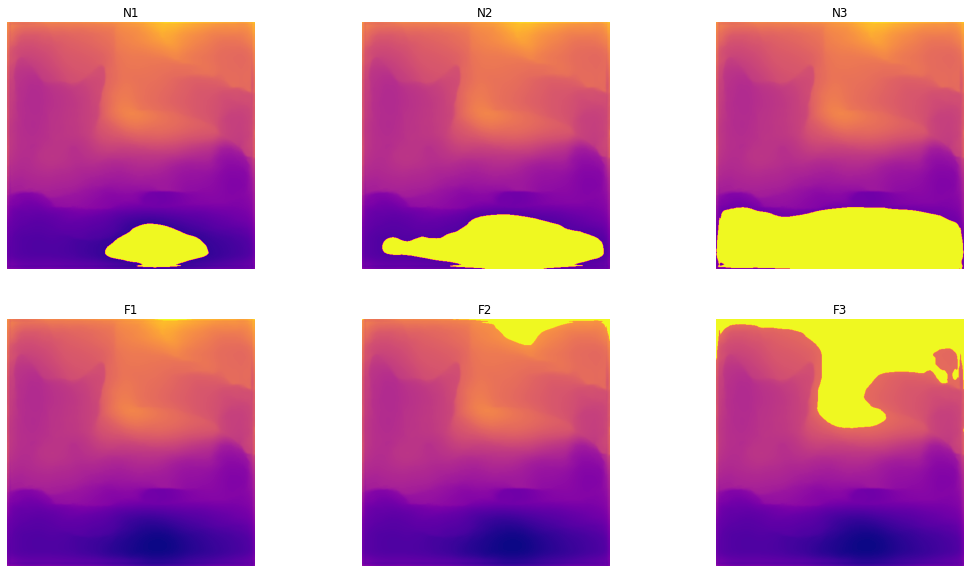

In [17]:
def get_blur_range(depth_img, min_, max_, background_max):
    #범위
    back1 = min_ / 3
    back2 = back1 * 2

    front1 = (background_max - max_) / 3 + max_
    front2 = 2 * (background_max - max_) / 3 + max_


    #동일 거리 영역 통합
    visual_list = [back1, back2, min_, front2, front1, max_]
    filter_list = []
    for idx, distance in enumerate(visual_list):
        filter_list += [np.where(
            depth_img < distance, 0, 1
        )] if idx // 3 == 0 else [np.where(
            depth_img > distance, 0, 1
        )]

    update_filter_list = []
    for idx in range(3):
        filter1 = filter_list[idx]
        filter2 = filter_list[idx + 3]
        update_filter_list += [filter1 + filter2]

    filter_list = update_filter_list.copy()
    update_filter_list = None
    
    return [filter_list, visual_list]


filter_list, visual_list = get_blur_range(depth_img, min_, max_, background_max)


#시각화
plt.figure(figsize=(18, 10))
for idx, distance in enumerate(visual_list):
    visual_filter = np.where(
        depth_img < distance, 1, depth_img
    ) if idx // 3 == 0 else np.where(
        depth_img > distance, 1, depth_img
    )
    
    
    plt.subplot(2, 3, idx+1)
    plt.axis("off")
    plt.imshow(visual_filter, cmap=plt.get_cmap("plasma"), vmin=0., vmax=1.)
    name = "N" if idx // 3 == 0 else "F"
    name += str(idx % 3 + 1) 
    plt.title(name)

#### 마스크 얻기
영역별 이미지 마스크를 얻습니다.

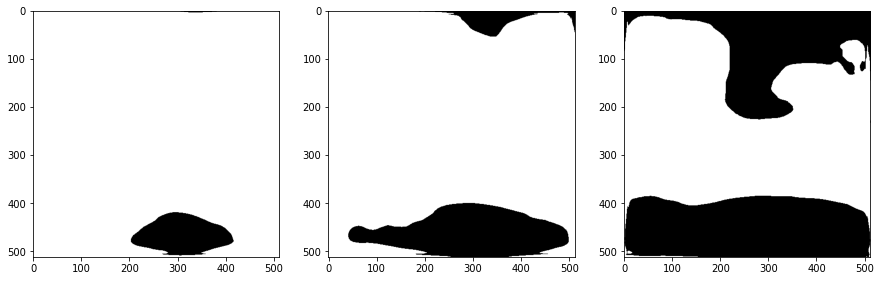

In [18]:
def get_mask_v2(filter_list, origin_img_shape, img_resized):
    img_show = img_resized.copy()

    img_mask_list = []
    for filter_ in filter_list:
        img_mask = filter_ * (255/filter_.max()) # 255 normalization
        img_mask = img_mask.astype(np.uint8)
        color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
        img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)


        img_mask_up = cv2.resize(img_mask, origin_img_shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
        img_mask_list += [img_mask_up]
    return img_mask_list


img_mask_list = get_mask_v2(filter_list, img.shape, img_resized)


#출력부
plt.figure(figsize=(15, 7))
for idx, filter_ in enumerate(img_mask_list):
    plt.subplot(1, 3, idx+1)
    plt.imshow(filter_, cmap=plt.cm.binary_r)

#### 합성
이미지 마스크를 토대로 영역별 블러처리 후 합성을 진행합니다. 고양이와 가까운 장식의 경우 선명하지만 멀어질수록 흐릿해지는 것을 확인할 수 있습니다.

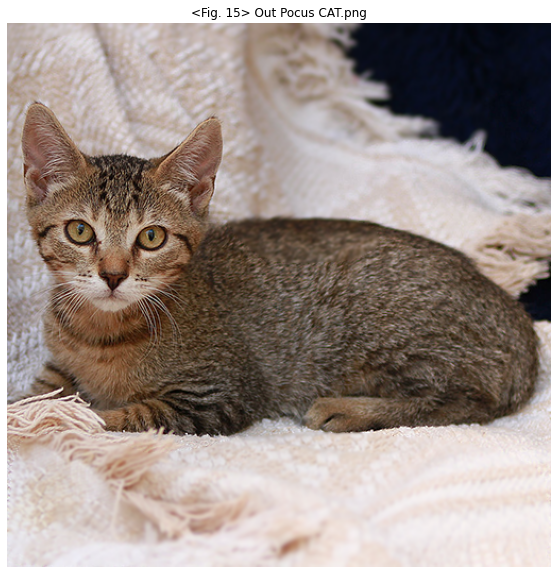

In [19]:
def do_outpocus(img, img_mask_list):
    over_write_img = img.copy()

    for img_mask in img_mask_list:
        img_orig_blur = cv2.GaussianBlur(over_write_img, (0, 0), 1.)
        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2RGB)
        img_bg_mask = cv2.bitwise_not(img_mask_color)
        img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

        over_write_img = np.where(img_mask_color==255, over_write_img, img_bg_blur)
    return over_write_img
    

over_write_img = do_outpocus(img, img_mask_list)


#출력부
show_one_img(over_write_img, "<Fig. 15> Out Pocus CAT.png", (10, 10))

#### 모듈 통합
모든 기능을 통합한 후, NOTEBOOK.png 이미지에 아웃포커싱 효과를 적용 합니다. 노트북이 블러처리 되지 않고 남자와 함께 출력됩니다.

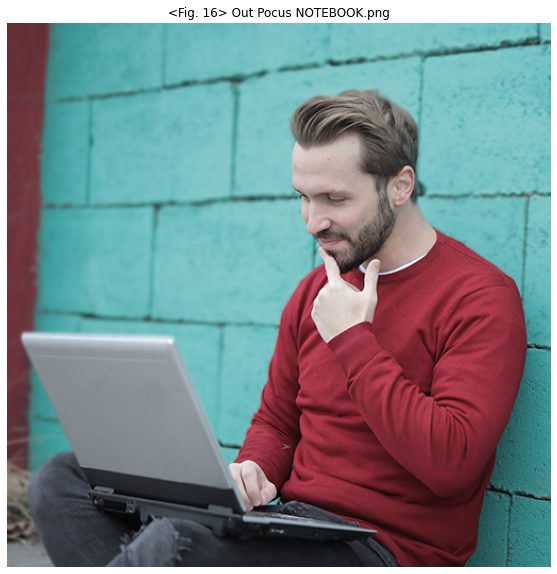

In [20]:
def get_outpocus_v2(img):
    rescaled = get_depth_map(img)
    img_resized, seg_map = MODEL.run(img)
    
    depth_img = cv2.resize(rescaled, dsize=seg_map.shape)   #resize

    #객체 범위 획득
    object_img = np.where(seg_map == seg_map.max(), 1, 0)   #객체 픽셀을 1로 변환
    object_depth = depth_img * object_img   #객체에 해당하는 픽셀은 0을 초과 하는 것을 이용
    background_max = depth_img.max()   #background의 가장 먼 거리
    max_ = np.percentile(object_depth, 98.)   #객체의 가장 먼 거리
    min_ = object_depth[np.where(object_depth > 0)].min()   #객체의 가장 가까운 거리

    filter_list, _ = get_blur_range(depth_img, min_, max_, background_max)
    
    img_mask_list = get_mask_v2(filter_list, img.shape, img_resized)
    
    over_write_img = do_outpocus(img, img_mask_list)

    return over_write_img
    
    
#출력부
img = load_img("./dataset/NOTEBOOK.png")
result = get_outpocus_v2(img)
show_one_img(result, "<Fig. 16> Out Pocus NOTEBOOK.png", (10, 10))

## 결론
이미지 세그멘테이션 모델을 활용하여 '배경 바꾸기' 및 '아웃포커싱 효과 적용하기' 를 진행하였습니다. 나아가 이미지 세그멘테이션 모델만을 활용하여 '아웃포커싱' 효과를 적용하는 것에 한계가 있어 Depth Map을 획득한 후 이를 적용하여 성능을 개선하였습니다. 하지만 해당 모델 또한 단일 이미지로부터 Depth Map을 구하기 때문에 정확한 수치를 제공해주지 못한다는 한계가 있습니다. 따라서 이러한 문제를 개선하기 위해 두 이미지의 시각 차를 이용한 Depth Map 구하기 등의 방안을 적용할 수 있습니다.

#### 회고
이미지로부터 Depth Map을 얻을 수 있었으며, 이를 아웃포커싱과의 관계에 적용할 수 있었고, 아이폰과 갤럭시에 적용되어 있는 인물사진 모드, 앱에서 사용하는 아웃포커싱 모드에 기본적인 기능을 배울수 있었습니다.